# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

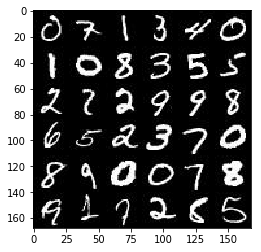

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

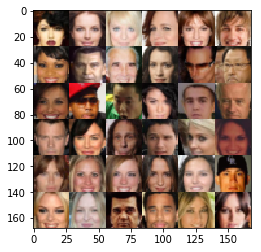

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real input images placeholder
    inputs_images = tf.placeholder( tf.float32, (None, image_width, image_height, image_channels), name = 'input_images')
    # Z input placeholder
    inputs_z = tf.placeholder( tf.float32, (None, z_dim), name = 'input_z' )
    # Learning rate placeholder
    learning_rate = tf.placeholder( tf.float32, name = 'learning_rate' )
    
    return inputs_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 (Input layer is 32x32x3)
        x1 = tf.layers.conv2d( images, filters = 64, kernel_size = 5, strides = 2, padding='same',
                               kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x1 = tf.maximum( alpha * x1, x1 )
        # 16x16x64
        
        # Layer 2
        x2 = tf.layers.conv2d( x1, filters = 128, kernel_size = 5, strides = 2, padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x2 = tf.layers.batch_normalization( x2, training = True )
        x2 = tf.maximum( alpha * x2, x2 )
        x2 = tf.nn.dropout( x2, keep_prob = keep_prob )
        # 8x8x128
        
        # Layer 3
        x3 = tf.layers.conv2d( x2, filters = 256, kernel_size = 5, strides = 2, padding='same', 
                               kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x3 = tf.layers.batch_normalization( x3, training = True )
        x3 = tf.maximum( alpha * x3, x3 )
        x3 = tf.nn.dropout( x3, keep_prob = keep_prob )
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape( x3, (-1, 4 * 4 * 256) )
        logits = tf.layers.dense( flat, 1 )
        out = tf.sigmoid( logits )
        
        
        '''#  Layer 1 (Input layer)
        x1 = tf.layers.conv2d( images, filters = 32, kernel_size = 5, strides = 2, padding = 'same',
                               kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x1 = tf.maximum( alpha * x1, x1 )
        
        # Layer 2
        x2 = tf.layers.conv2d( images, filters = 64, kernel_size = 5, strides = 2, padding = 'same',
                               kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x2 = tf.layers.batch_normalization( x2, training = True)
        x2 = tf.maximum( alpha * x2, x2 )
        x2 = tf.nn.dropout( x2, keep_prob = keep_prob )
        
        # Layer 3
        x3 = tf.layers.conv2d( x2, filters = 128, kernel_size = 5, strides = 2, padding='same', 
                               kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x3 = tf.layers.batch_normalization( x3, training = True )
        x3 = tf.maximum( alpha * x3, x3 )
        x3 = tf.nn.dropout( x3, keep_prob = keep_prob )
                
        # Layer 4
        x4 = tf.layers.conv2d( x3, filters = 256, kernel_size = 5, strides = 2, padding='same', 
                               kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x4 = tf.layers.batch_normalization( x4, training = True )
        x4 = tf.maximum( alpha * x4, x4 )
        x4 = tf.nn.dropout( x4, keep_prob = keep_prob )
        
        # Flatten it
        flat = tf.reshape( x4, (-1, 2 * 2 * 256) )
        logits = tf.layers.dense( flat, 1, activation = None )
        out = tf.sigmoid( logits )'''

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense( z, 7 * 7 * 512 )
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape( x1, (-1, 7, 7, 512) )
        x1 = tf.layers.batch_normalization( x1, training = is_train )
        x1 = tf.maximum( alpha * x1, x1 )
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose( x1, filters = 256, kernel_size = 5, strides = 2, padding = 'same',
                                         kernel_initializer = tf.contrib.layers.xavier_initializer() )       
        x2 = tf.layers.batch_normalization( x2, training = is_train )
        x2 = tf.maximum( alpha * x2, x2 )
        x2 = tf.nn.dropout( x2, keep_prob = keep_prob )
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose( x2, filters = 128,  kernel_size = 5, strides = 2, padding = 'same',
                                         kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x3 = tf.layers.batch_normalization( x3, training=is_train )
        x3 = tf.maximum( alpha * x3, x3 )
        x3 = tf.nn.dropout( x3, keep_prob = keep_prob )
        # 28x28x128 now
        
        x4 = tf.layers.conv2d_transpose( x3, filters = 64, kernel_size = 5, strides = 1, padding = 'same',
                                         kernel_initializer = tf.contrib.layers.xavier_initializer() )
        x4 = tf.layers.batch_normalization( x3, training=is_train )
        x4 = tf.maximum( alpha * x4, x4 )
        x4 = tf.nn.dropout( x4, keep_prob = keep_prob )
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose( x4, out_channel_dim, 3, strides=1, padding='same' )
        # 28x28x5 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator model
    g_model = generator( input_z, out_channel_dim )
    
    # discriminator model
    d_model_real, d_logits_real = discriminator( input_real )
    d_model_fake, d_logits_fake = discriminator( g_model, reuse = True )
    
    # generator loss
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = d_logits_fake, 
                                                                      labels = tf.ones_like(d_model_fake)*(1 -smooth) ) )
    # discriminator loss
    # Using smoother label technique to improve performance. 
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = d_logits_real, 
                                                                           labels = tf.ones_like(d_model_real)*(1 -smooth) ) )    
    
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = d_logits_fake, 
                                                                           labels = tf.zeros_like(d_model_fake)*(1 -smooth) ) )
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables( )
    d_vars = [ var for var in t_vars if var.name.startswith('discriminator') ]
    g_vars = [ var for var in t_vars if var.name.startswith('generator') ]

    # Optimize
    with tf.control_dependencies( tf.get_collection(tf.GraphKeys.UPDATE_OPS) ):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    # Building Model
    _, image_width, image_height, image_channels = data_shape
    
    input_images, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    discriminator_loss, genator_loss = model_loss(input_images, input_z, image_channels)
    discriminator_opt,  genator_opt  = model_opt(discriminator_loss, genator_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Trainning Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform( -1, 1, size = (batch_size, z_dim) )

                # Run optimizers
                _ = sess.run( discriminator_opt, 
                              feed_dict = { input_images: batch_images, input_z: batch_z, lr: learning_rate } )
                _ = sess.run( genator_opt,  
                              feed_dict = { input_images: batch_images, input_z: batch_z, lr: learning_rate } )

                # Print the initial output
                if steps == 1:
                    print( "Initial output: ")
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                
                # Print the losses at the end of each epoch
                if steps % 10 == 0:
                    train_loss_d = discriminator_loss.eval( {input_z: batch_z, input_images: batch_images} )
                    train_loss_g = genator_loss.eval( {input_z: batch_z} )
         
                    print( "Epoch {}/{}...".format( epoch_i + 1, epochs ),
                           "Generator Loss: {:.4f}".format( train_loss_g ),
                           "Discriminator Loss: {:.4f}...".format( train_loss_d ) )
                    
                    # Save losses to view after training
                    losses.append( (train_loss_d, train_loss_g) )

                if steps % 100 == 0:
                    show_generator_output( sess, 16, input_z, image_channels, data_image_mode )
                    
        saver.save(sess, './generator.ckpt')
    
    return losses

print("Train ok")

Train ok


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Initial output: 


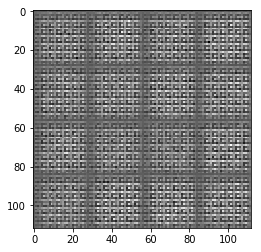

Epoch 1/2... Generator Loss: 3.9134 Discriminator Loss: 0.4761...
Epoch 1/2... Generator Loss: 1.6335 Discriminator Loss: 0.5702...
Epoch 1/2... Generator Loss: 4.9370 Discriminator Loss: 1.4278...
Epoch 1/2... Generator Loss: 3.7047 Discriminator Loss: 1.8001...
Epoch 1/2... Generator Loss: 3.6840 Discriminator Loss: 1.7059...
Epoch 1/2... Generator Loss: 1.8989 Discriminator Loss: 1.5432...
Epoch 1/2... Generator Loss: 1.9521 Discriminator Loss: 1.4728...
Epoch 1/2... Generator Loss: 2.7463 Discriminator Loss: 1.5247...
Epoch 1/2... Generator Loss: 2.8211 Discriminator Loss: 1.0792...
Epoch 1/2... Generator Loss: 2.9259 Discriminator Loss: 0.9585...


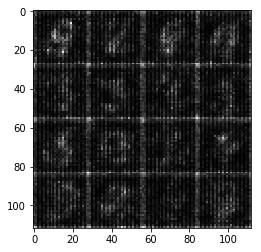

Epoch 1/2... Generator Loss: 2.5608 Discriminator Loss: 0.5152...
Epoch 1/2... Generator Loss: 0.4749 Discriminator Loss: 1.6782...
Epoch 1/2... Generator Loss: 2.5447 Discriminator Loss: 0.5167...
Epoch 1/2... Generator Loss: 6.0426 Discriminator Loss: 2.9627...
Epoch 1/2... Generator Loss: 3.7189 Discriminator Loss: 0.4478...
Epoch 1/2... Generator Loss: 6.3965 Discriminator Loss: 1.5572...
Epoch 1/2... Generator Loss: 2.8445 Discriminator Loss: 0.4166...
Epoch 1/2... Generator Loss: 3.1673 Discriminator Loss: 0.3883...
Epoch 1/2... Generator Loss: 4.5802 Discriminator Loss: 0.3880...
Epoch 1/2... Generator Loss: 3.6604 Discriminator Loss: 0.3842...


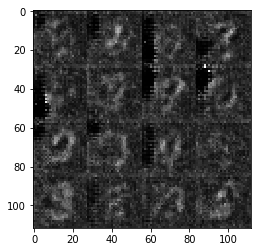

Epoch 1/2... Generator Loss: 3.4904 Discriminator Loss: 0.3893...
Epoch 1/2... Generator Loss: 3.8929 Discriminator Loss: 0.3663...
Epoch 1/2... Generator Loss: 4.4805 Discriminator Loss: 0.3674...
Epoch 1/2... Generator Loss: 2.1248 Discriminator Loss: 0.8456...
Epoch 1/2... Generator Loss: 2.2272 Discriminator Loss: 1.0781...
Epoch 1/2... Generator Loss: 3.2754 Discriminator Loss: 1.0036...
Epoch 1/2... Generator Loss: 2.1380 Discriminator Loss: 0.6988...
Epoch 1/2... Generator Loss: 1.6788 Discriminator Loss: 0.5517...
Epoch 1/2... Generator Loss: 2.6523 Discriminator Loss: 0.4248...
Epoch 1/2... Generator Loss: 3.0517 Discriminator Loss: 0.3988...


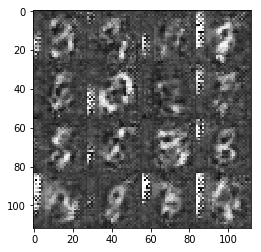

Epoch 1/2... Generator Loss: 3.0529 Discriminator Loss: 0.4240...
Epoch 1/2... Generator Loss: 3.2646 Discriminator Loss: 0.3883...
Epoch 1/2... Generator Loss: 2.7688 Discriminator Loss: 0.4275...
Epoch 1/2... Generator Loss: 4.7387 Discriminator Loss: 0.3464...
Epoch 1/2... Generator Loss: 2.6470 Discriminator Loss: 0.4600...
Epoch 1/2... Generator Loss: 0.3649 Discriminator Loss: 3.7705...
Epoch 1/2... Generator Loss: 1.8664 Discriminator Loss: 0.5970...
Epoch 1/2... Generator Loss: 1.9674 Discriminator Loss: 0.6052...
Epoch 1/2... Generator Loss: 3.5979 Discriminator Loss: 0.3815...
Epoch 1/2... Generator Loss: 3.3325 Discriminator Loss: 0.4062...


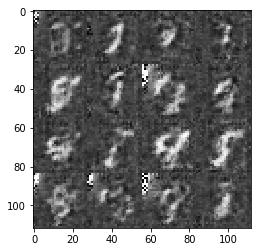

Epoch 1/2... Generator Loss: 3.2649 Discriminator Loss: 0.3996...
Epoch 1/2... Generator Loss: 4.7881 Discriminator Loss: 1.8426...
Epoch 1/2... Generator Loss: 1.6792 Discriminator Loss: 0.6866...
Epoch 1/2... Generator Loss: 2.5579 Discriminator Loss: 0.4584...
Epoch 1/2... Generator Loss: 2.1695 Discriminator Loss: 0.5628...
Epoch 1/2... Generator Loss: 2.5240 Discriminator Loss: 1.2471...
Epoch 2/2... Generator Loss: 0.5811 Discriminator Loss: 1.3780...
Epoch 2/2... Generator Loss: 1.0086 Discriminator Loss: 1.0321...
Epoch 2/2... Generator Loss: 2.0914 Discriminator Loss: 0.5578...
Epoch 2/2... Generator Loss: 2.6542 Discriminator Loss: 0.4602...


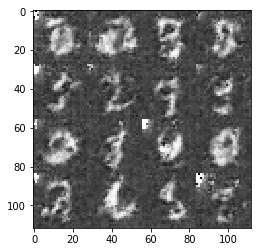

Epoch 2/2... Generator Loss: 2.4126 Discriminator Loss: 0.5221...
Epoch 2/2... Generator Loss: 2.0411 Discriminator Loss: 0.8316...
Epoch 2/2... Generator Loss: 2.5233 Discriminator Loss: 0.4724...
Epoch 2/2... Generator Loss: 2.2671 Discriminator Loss: 0.4816...
Epoch 2/2... Generator Loss: 2.1226 Discriminator Loss: 0.6151...
Epoch 2/2... Generator Loss: 3.5300 Discriminator Loss: 0.3753...
Epoch 2/2... Generator Loss: 2.5161 Discriminator Loss: 0.4662...
Epoch 2/2... Generator Loss: 3.5277 Discriminator Loss: 0.4028...
Epoch 2/2... Generator Loss: 3.1934 Discriminator Loss: 0.4105...
Epoch 2/2... Generator Loss: 2.7662 Discriminator Loss: 1.0509...


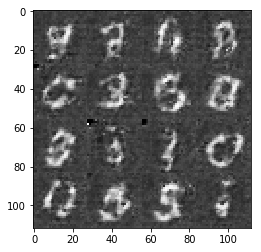

Epoch 2/2... Generator Loss: 3.1030 Discriminator Loss: 0.6135...
Epoch 2/2... Generator Loss: 2.9093 Discriminator Loss: 0.4798...
Epoch 2/2... Generator Loss: 3.2218 Discriminator Loss: 0.4159...
Epoch 2/2... Generator Loss: 2.8954 Discriminator Loss: 0.4705...
Epoch 2/2... Generator Loss: 3.0934 Discriminator Loss: 0.4069...
Epoch 2/2... Generator Loss: 3.9960 Discriminator Loss: 0.3640...
Epoch 2/2... Generator Loss: 3.7299 Discriminator Loss: 0.4000...
Epoch 2/2... Generator Loss: 3.0483 Discriminator Loss: 0.4235...
Epoch 2/2... Generator Loss: 0.7541 Discriminator Loss: 1.4341...
Epoch 2/2... Generator Loss: 0.5427 Discriminator Loss: 1.6438...


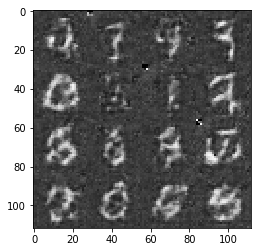

Epoch 2/2... Generator Loss: 3.5796 Discriminator Loss: 0.4928...
Epoch 2/2... Generator Loss: 2.1567 Discriminator Loss: 0.5450...
Epoch 2/2... Generator Loss: 3.8560 Discriminator Loss: 0.3859...
Epoch 2/2... Generator Loss: 3.5153 Discriminator Loss: 0.3959...
Epoch 2/2... Generator Loss: 3.9451 Discriminator Loss: 0.3691...
Epoch 2/2... Generator Loss: 3.3922 Discriminator Loss: 0.3878...
Epoch 2/2... Generator Loss: 3.9856 Discriminator Loss: 0.3630...
Epoch 2/2... Generator Loss: 4.1425 Discriminator Loss: 0.3711...
Epoch 2/2... Generator Loss: 3.0314 Discriminator Loss: 0.3967...
Epoch 2/2... Generator Loss: 4.3753 Discriminator Loss: 0.3502...


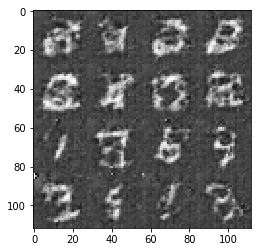

Epoch 2/2... Generator Loss: 2.8604 Discriminator Loss: 0.5299...
Epoch 2/2... Generator Loss: 2.2903 Discriminator Loss: 0.5791...
Epoch 2/2... Generator Loss: 2.1882 Discriminator Loss: 0.5088...
Epoch 2/2... Generator Loss: 2.8394 Discriminator Loss: 0.4127...
Epoch 2/2... Generator Loss: 4.0144 Discriminator Loss: 0.3894...
Epoch 2/2... Generator Loss: 6.4157 Discriminator Loss: 0.3426...
Epoch 2/2... Generator Loss: 3.7332 Discriminator Loss: 0.3598...
Epoch 2/2... Generator Loss: 3.4048 Discriminator Loss: 0.3788...
Epoch 2/2... Generator Loss: 4.2479 Discriminator Loss: 0.3547...
Epoch 2/2... Generator Loss: 3.4328 Discriminator Loss: 0.3809...


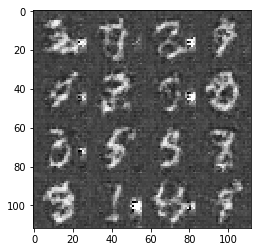

Epoch 2/2... Generator Loss: 3.1342 Discriminator Loss: 0.3994...
Epoch 2/2... Generator Loss: 3.7410 Discriminator Loss: 3.1185...
Epoch 2/2... Generator Loss: 2.6027 Discriminator Loss: 1.2087...


In [19]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Initial output: 


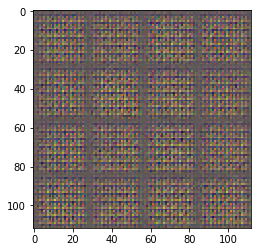

Epoch 1/1... Generator Loss: 6.7407 Discriminator Loss: 0.4873...
Epoch 1/1... Generator Loss: 2.4648 Discriminator Loss: 0.5625...
Epoch 1/1... Generator Loss: 20.6531 Discriminator Loss: 10.7502...
Epoch 1/1... Generator Loss: 0.7522 Discriminator Loss: 1.5151...
Epoch 1/1... Generator Loss: 0.3687 Discriminator Loss: 2.9379...
Epoch 1/1... Generator Loss: 1.0628 Discriminator Loss: 0.9036...
Epoch 1/1... Generator Loss: 2.2533 Discriminator Loss: 0.5059...
Epoch 1/1... Generator Loss: 3.9024 Discriminator Loss: 0.4009...
Epoch 1/1... Generator Loss: 1.6655 Discriminator Loss: 0.6102...
Epoch 1/1... Generator Loss: 3.0618 Discriminator Loss: 0.3893...


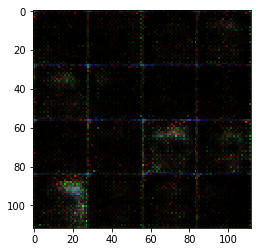

Epoch 1/1... Generator Loss: 0.8932 Discriminator Loss: 1.1318...
Epoch 1/1... Generator Loss: 0.7562 Discriminator Loss: 1.1174...
Epoch 1/1... Generator Loss: 3.8563 Discriminator Loss: 0.3839...
Epoch 1/1... Generator Loss: 2.6398 Discriminator Loss: 0.4781...
Epoch 1/1... Generator Loss: 5.8124 Discriminator Loss: 0.3707...
Epoch 1/1... Generator Loss: 3.6185 Discriminator Loss: 0.3620...
Epoch 1/1... Generator Loss: 3.8970 Discriminator Loss: 0.3864...
Epoch 1/1... Generator Loss: 0.3616 Discriminator Loss: 3.1972...
Epoch 1/1... Generator Loss: 2.4666 Discriminator Loss: 0.4467...
Epoch 1/1... Generator Loss: 2.2969 Discriminator Loss: 0.4443...


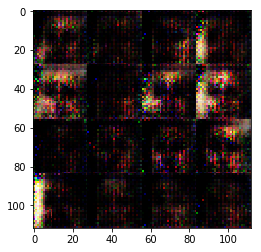

Epoch 1/1... Generator Loss: 1.0066 Discriminator Loss: 1.1801...
Epoch 1/1... Generator Loss: 2.2997 Discriminator Loss: 0.4833...
Epoch 1/1... Generator Loss: 0.6002 Discriminator Loss: 1.4474...
Epoch 1/1... Generator Loss: 1.9457 Discriminator Loss: 0.5593...
Epoch 1/1... Generator Loss: 2.6373 Discriminator Loss: 0.4837...
Epoch 1/1... Generator Loss: 3.4961 Discriminator Loss: 0.3794...
Epoch 1/1... Generator Loss: 2.5882 Discriminator Loss: 0.4466...
Epoch 1/1... Generator Loss: 2.7421 Discriminator Loss: 0.4435...
Epoch 1/1... Generator Loss: 3.1873 Discriminator Loss: 0.4015...
Epoch 1/1... Generator Loss: 1.5859 Discriminator Loss: 0.9856...


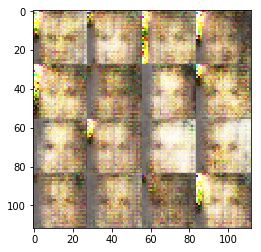

Epoch 1/1... Generator Loss: 2.7284 Discriminator Loss: 5.3089...
Epoch 1/1... Generator Loss: 0.7681 Discriminator Loss: 1.3079...
Epoch 1/1... Generator Loss: 0.9542 Discriminator Loss: 1.1908...
Epoch 1/1... Generator Loss: 1.6407 Discriminator Loss: 0.9939...
Epoch 1/1... Generator Loss: 0.9797 Discriminator Loss: 0.9198...
Epoch 1/1... Generator Loss: 2.2569 Discriminator Loss: 0.4600...
Epoch 1/1... Generator Loss: 2.7115 Discriminator Loss: 0.4212...
Epoch 1/1... Generator Loss: 1.8092 Discriminator Loss: 0.5793...
Epoch 1/1... Generator Loss: 3.2799 Discriminator Loss: 0.4093...
Epoch 1/1... Generator Loss: 2.9295 Discriminator Loss: 0.4228...


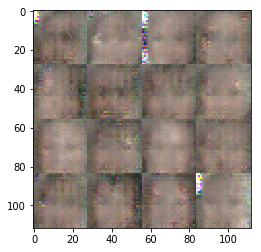

Epoch 1/1... Generator Loss: 0.6764 Discriminator Loss: 1.8028...
Epoch 1/1... Generator Loss: 0.8807 Discriminator Loss: 1.4219...
Epoch 1/1... Generator Loss: 0.8291 Discriminator Loss: 1.1943...
Epoch 1/1... Generator Loss: 0.9516 Discriminator Loss: 0.9947...
Epoch 1/1... Generator Loss: 1.6108 Discriminator Loss: 0.6918...
Epoch 1/1... Generator Loss: 1.8576 Discriminator Loss: 0.8219...
Epoch 1/1... Generator Loss: 3.7255 Discriminator Loss: 3.5477...
Epoch 1/1... Generator Loss: 2.2093 Discriminator Loss: 0.5076...
Epoch 1/1... Generator Loss: 1.9281 Discriminator Loss: 0.5708...
Epoch 1/1... Generator Loss: 0.6812 Discriminator Loss: 2.0905...


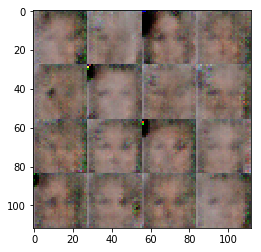

Epoch 1/1... Generator Loss: 1.9690 Discriminator Loss: 0.5138...
Epoch 1/1... Generator Loss: 2.5534 Discriminator Loss: 1.8753...
Epoch 1/1... Generator Loss: 1.1785 Discriminator Loss: 0.8985...
Epoch 1/1... Generator Loss: 0.3960 Discriminator Loss: 2.3153...
Epoch 1/1... Generator Loss: 2.2871 Discriminator Loss: 0.5173...
Epoch 1/1... Generator Loss: 2.7925 Discriminator Loss: 0.4463...
Epoch 1/1... Generator Loss: 2.8818 Discriminator Loss: 0.4083...
Epoch 1/1... Generator Loss: 3.6413 Discriminator Loss: 2.3509...
Epoch 1/1... Generator Loss: 0.5551 Discriminator Loss: 1.5780...
Epoch 1/1... Generator Loss: 3.5183 Discriminator Loss: 1.7930...


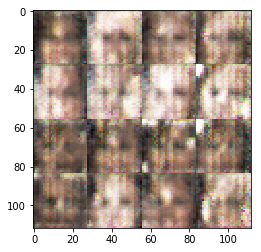

Epoch 1/1... Generator Loss: 1.9841 Discriminator Loss: 0.6776...
Epoch 1/1... Generator Loss: 1.9973 Discriminator Loss: 0.5042...
Epoch 1/1... Generator Loss: 1.2927 Discriminator Loss: 0.9022...
Epoch 1/1... Generator Loss: 2.9424 Discriminator Loss: 0.4025...
Epoch 1/1... Generator Loss: 2.6512 Discriminator Loss: 0.4263...
Epoch 1/1... Generator Loss: 2.7516 Discriminator Loss: 0.4334...
Epoch 1/1... Generator Loss: 1.6833 Discriminator Loss: 0.7132...
Epoch 1/1... Generator Loss: 1.6146 Discriminator Loss: 0.6089...
Epoch 1/1... Generator Loss: 0.3808 Discriminator Loss: 2.3363...
Epoch 1/1... Generator Loss: 0.4704 Discriminator Loss: 1.5406...


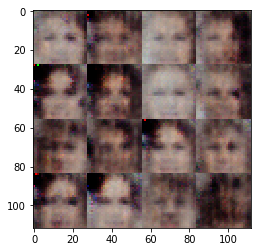

Epoch 1/1... Generator Loss: 2.1051 Discriminator Loss: 0.5410...
Epoch 1/1... Generator Loss: 2.3012 Discriminator Loss: 0.4964...
Epoch 1/1... Generator Loss: 2.5221 Discriminator Loss: 0.4480...
Epoch 1/1... Generator Loss: 2.0156 Discriminator Loss: 0.5145...
Epoch 1/1... Generator Loss: 1.3204 Discriminator Loss: 0.7489...
Epoch 1/1... Generator Loss: 1.7446 Discriminator Loss: 0.5093...
Epoch 1/1... Generator Loss: 3.0642 Discriminator Loss: 0.3993...
Epoch 1/1... Generator Loss: 2.8823 Discriminator Loss: 0.4076...
Epoch 1/1... Generator Loss: 3.6776 Discriminator Loss: 1.9228...
Epoch 1/1... Generator Loss: 1.4047 Discriminator Loss: 0.8379...


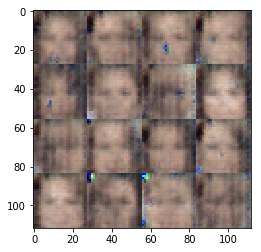

Epoch 1/1... Generator Loss: 2.2484 Discriminator Loss: 0.4637...
Epoch 1/1... Generator Loss: 2.9559 Discriminator Loss: 0.6517...
Epoch 1/1... Generator Loss: 2.0382 Discriminator Loss: 0.4503...
Epoch 1/1... Generator Loss: 3.5757 Discriminator Loss: 0.4068...
Epoch 1/1... Generator Loss: 0.3403 Discriminator Loss: 4.2371...
Epoch 1/1... Generator Loss: 0.7484 Discriminator Loss: 1.4253...
Epoch 1/1... Generator Loss: 0.8570 Discriminator Loss: 1.5897...
Epoch 1/1... Generator Loss: 0.9232 Discriminator Loss: 1.2487...
Epoch 1/1... Generator Loss: 1.4320 Discriminator Loss: 1.0469...
Epoch 1/1... Generator Loss: 1.7045 Discriminator Loss: 0.5360...


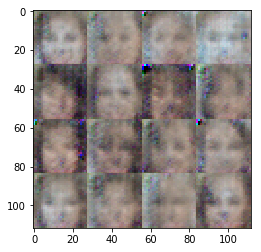

Epoch 1/1... Generator Loss: 2.0051 Discriminator Loss: 0.7865...
Epoch 1/1... Generator Loss: 1.4810 Discriminator Loss: 0.6958...
Epoch 1/1... Generator Loss: 2.1850 Discriminator Loss: 0.4862...
Epoch 1/1... Generator Loss: 0.3913 Discriminator Loss: 2.1274...
Epoch 1/1... Generator Loss: 0.5286 Discriminator Loss: 1.9022...
Epoch 1/1... Generator Loss: 1.3518 Discriminator Loss: 0.8998...
Epoch 1/1... Generator Loss: 2.0224 Discriminator Loss: 0.5871...
Epoch 1/1... Generator Loss: 1.6307 Discriminator Loss: 0.5895...
Epoch 1/1... Generator Loss: 1.7821 Discriminator Loss: 0.8359...
Epoch 1/1... Generator Loss: 2.7682 Discriminator Loss: 0.4081...


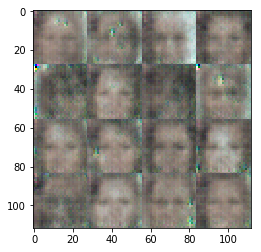

Epoch 1/1... Generator Loss: 2.6488 Discriminator Loss: 0.4250...
Epoch 1/1... Generator Loss: 4.0792 Discriminator Loss: 1.0822...
Epoch 1/1... Generator Loss: 2.2357 Discriminator Loss: 0.4817...
Epoch 1/1... Generator Loss: 2.8565 Discriminator Loss: 0.9822...
Epoch 1/1... Generator Loss: 1.8378 Discriminator Loss: 0.5827...
Epoch 1/1... Generator Loss: 1.2330 Discriminator Loss: 0.9593...
Epoch 1/1... Generator Loss: 3.6990 Discriminator Loss: 1.3027...
Epoch 1/1... Generator Loss: 1.2293 Discriminator Loss: 1.2689...
Epoch 1/1... Generator Loss: 1.6333 Discriminator Loss: 1.0053...
Epoch 1/1... Generator Loss: 2.2355 Discriminator Loss: 1.9931...


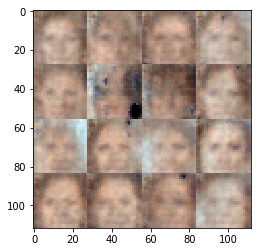

Epoch 1/1... Generator Loss: 1.9626 Discriminator Loss: 0.5823...
Epoch 1/1... Generator Loss: 1.6925 Discriminator Loss: 0.6659...
Epoch 1/1... Generator Loss: 2.3874 Discriminator Loss: 0.4432...
Epoch 1/1... Generator Loss: 4.7679 Discriminator Loss: 0.3458...
Epoch 1/1... Generator Loss: 3.2735 Discriminator Loss: 0.4048...
Epoch 1/1... Generator Loss: 1.2740 Discriminator Loss: 0.6999...
Epoch 1/1... Generator Loss: 1.4567 Discriminator Loss: 1.4598...
Epoch 1/1... Generator Loss: 1.3817 Discriminator Loss: 1.4338...
Epoch 1/1... Generator Loss: 0.8268 Discriminator Loss: 1.3264...
Epoch 1/1... Generator Loss: 1.2155 Discriminator Loss: 1.4651...


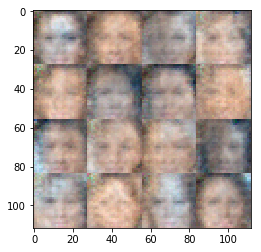

Epoch 1/1... Generator Loss: 0.7721 Discriminator Loss: 1.3528...
Epoch 1/1... Generator Loss: 0.6046 Discriminator Loss: 1.3431...
Epoch 1/1... Generator Loss: 0.6556 Discriminator Loss: 1.3254...
Epoch 1/1... Generator Loss: 0.5764 Discriminator Loss: 1.4812...
Epoch 1/1... Generator Loss: 0.9730 Discriminator Loss: 1.2321...
Epoch 1/1... Generator Loss: 0.9886 Discriminator Loss: 1.3171...
Epoch 1/1... Generator Loss: 1.0059 Discriminator Loss: 1.2395...
Epoch 1/1... Generator Loss: 1.2999 Discriminator Loss: 1.4925...
Epoch 1/1... Generator Loss: 0.9664 Discriminator Loss: 1.2927...
Epoch 1/1... Generator Loss: 0.4622 Discriminator Loss: 1.5676...


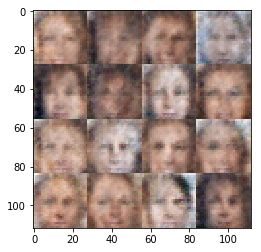

Epoch 1/1... Generator Loss: 0.5611 Discriminator Loss: 1.4167...
Epoch 1/1... Generator Loss: 0.7558 Discriminator Loss: 1.3597...
Epoch 1/1... Generator Loss: 0.7156 Discriminator Loss: 1.3075...
Epoch 1/1... Generator Loss: 1.0951 Discriminator Loss: 1.3354...
Epoch 1/1... Generator Loss: 0.9998 Discriminator Loss: 1.3252...
Epoch 1/1... Generator Loss: 0.8695 Discriminator Loss: 1.3096...
Epoch 1/1... Generator Loss: 0.6407 Discriminator Loss: 1.4806...
Epoch 1/1... Generator Loss: 0.9461 Discriminator Loss: 1.3476...
Epoch 1/1... Generator Loss: 1.1051 Discriminator Loss: 1.4763...
Epoch 1/1... Generator Loss: 0.6350 Discriminator Loss: 1.4081...


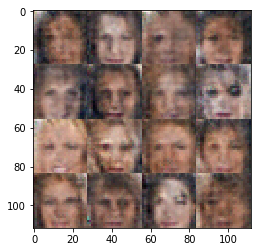

Epoch 1/1... Generator Loss: 0.7301 Discriminator Loss: 1.4029...
Epoch 1/1... Generator Loss: 0.9790 Discriminator Loss: 1.3372...
Epoch 1/1... Generator Loss: 0.6914 Discriminator Loss: 1.3580...
Epoch 1/1... Generator Loss: 1.3501 Discriminator Loss: 1.3943...
Epoch 1/1... Generator Loss: 1.0045 Discriminator Loss: 1.3728...
Epoch 1/1... Generator Loss: 0.9663 Discriminator Loss: 1.3119...
Epoch 1/1... Generator Loss: 0.8723 Discriminator Loss: 1.3861...
Epoch 1/1... Generator Loss: 0.7932 Discriminator Loss: 1.3526...
Epoch 1/1... Generator Loss: 1.1742 Discriminator Loss: 1.3705...
Epoch 1/1... Generator Loss: 0.7894 Discriminator Loss: 1.3955...


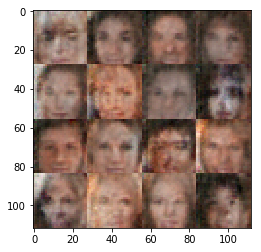

Epoch 1/1... Generator Loss: 0.8816 Discriminator Loss: 1.2722...
Epoch 1/1... Generator Loss: 0.9223 Discriminator Loss: 1.3494...
Epoch 1/1... Generator Loss: 0.9106 Discriminator Loss: 1.3732...
Epoch 1/1... Generator Loss: 0.7779 Discriminator Loss: 1.3050...
Epoch 1/1... Generator Loss: 0.7257 Discriminator Loss: 1.3091...
Epoch 1/1... Generator Loss: 0.9193 Discriminator Loss: 1.2431...
Epoch 1/1... Generator Loss: 0.8253 Discriminator Loss: 1.3904...
Epoch 1/1... Generator Loss: 0.7303 Discriminator Loss: 1.3579...
Epoch 1/1... Generator Loss: 0.7115 Discriminator Loss: 1.4072...
Epoch 1/1... Generator Loss: 0.5655 Discriminator Loss: 1.5367...


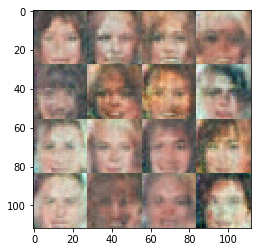

Epoch 1/1... Generator Loss: 1.0918 Discriminator Loss: 1.3322...
Epoch 1/1... Generator Loss: 0.9223 Discriminator Loss: 1.3778...
Epoch 1/1... Generator Loss: 1.2106 Discriminator Loss: 1.3748...
Epoch 1/1... Generator Loss: 1.1853 Discriminator Loss: 1.3519...
Epoch 1/1... Generator Loss: 0.9008 Discriminator Loss: 1.3396...
Epoch 1/1... Generator Loss: 0.6298 Discriminator Loss: 1.3150...
Epoch 1/1... Generator Loss: 0.6221 Discriminator Loss: 1.4171...
Epoch 1/1... Generator Loss: 0.6884 Discriminator Loss: 1.3816...
Epoch 1/1... Generator Loss: 0.8214 Discriminator Loss: 1.3813...
Epoch 1/1... Generator Loss: 0.9713 Discriminator Loss: 1.4343...


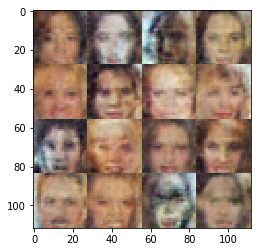

Epoch 1/1... Generator Loss: 0.9413 Discriminator Loss: 1.3022...
Epoch 1/1... Generator Loss: 0.7213 Discriminator Loss: 1.3682...
Epoch 1/1... Generator Loss: 0.7413 Discriminator Loss: 1.3086...
Epoch 1/1... Generator Loss: 0.8176 Discriminator Loss: 1.3345...
Epoch 1/1... Generator Loss: 0.4550 Discriminator Loss: 1.6456...
Epoch 1/1... Generator Loss: 0.6374 Discriminator Loss: 1.3624...
Epoch 1/1... Generator Loss: 0.5303 Discriminator Loss: 1.5230...
Epoch 1/1... Generator Loss: 0.8780 Discriminator Loss: 1.1726...
Epoch 1/1... Generator Loss: 0.7555 Discriminator Loss: 1.3737...
Epoch 1/1... Generator Loss: 0.7237 Discriminator Loss: 1.2319...


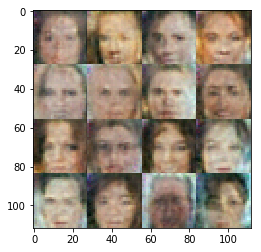

Epoch 1/1... Generator Loss: 0.5149 Discriminator Loss: 1.4639...
Epoch 1/1... Generator Loss: 1.1207 Discriminator Loss: 0.7546...
Epoch 1/1... Generator Loss: 1.1947 Discriminator Loss: 0.7065...
Epoch 1/1... Generator Loss: 2.7489 Discriminator Loss: 3.1947...
Epoch 1/1... Generator Loss: 1.4337 Discriminator Loss: 0.9664...
Epoch 1/1... Generator Loss: 0.5943 Discriminator Loss: 1.3506...
Epoch 1/1... Generator Loss: 0.6515 Discriminator Loss: 1.4271...
Epoch 1/1... Generator Loss: 0.6482 Discriminator Loss: 1.2382...
Epoch 1/1... Generator Loss: 2.8254 Discriminator Loss: 0.5126...
Epoch 1/1... Generator Loss: 1.4727 Discriminator Loss: 0.5737...


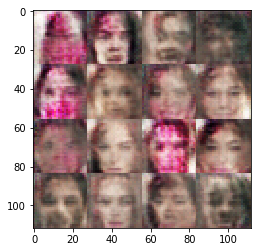

Epoch 1/1... Generator Loss: 1.0105 Discriminator Loss: 1.3205...
Epoch 1/1... Generator Loss: 3.0219 Discriminator Loss: 2.5265...
Epoch 1/1... Generator Loss: 0.8272 Discriminator Loss: 1.2416...
Epoch 1/1... Generator Loss: 0.5400 Discriminator Loss: 1.3487...
Epoch 1/1... Generator Loss: 2.5344 Discriminator Loss: 0.4519...
Epoch 1/1... Generator Loss: 0.4662 Discriminator Loss: 1.7633...
Epoch 1/1... Generator Loss: 1.2529 Discriminator Loss: 1.2391...
Epoch 1/1... Generator Loss: 1.4111 Discriminator Loss: 1.3693...
Epoch 1/1... Generator Loss: 2.1639 Discriminator Loss: 0.6765...
Epoch 1/1... Generator Loss: 0.8765 Discriminator Loss: 1.3679...


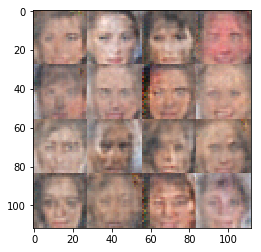

Epoch 1/1... Generator Loss: 0.7360 Discriminator Loss: 1.3868...
Epoch 1/1... Generator Loss: 0.8620 Discriminator Loss: 1.3592...
Epoch 1/1... Generator Loss: 0.7919 Discriminator Loss: 1.3054...
Epoch 1/1... Generator Loss: 0.7511 Discriminator Loss: 1.3270...
Epoch 1/1... Generator Loss: 0.5865 Discriminator Loss: 1.4265...
Epoch 1/1... Generator Loss: 0.6471 Discriminator Loss: 1.2906...
Epoch 1/1... Generator Loss: 1.5543 Discriminator Loss: 1.9959...
Epoch 1/1... Generator Loss: 0.9303 Discriminator Loss: 1.2049...
Epoch 1/1... Generator Loss: 1.0106 Discriminator Loss: 1.4449...
Epoch 1/1... Generator Loss: 0.7398 Discriminator Loss: 1.3599...


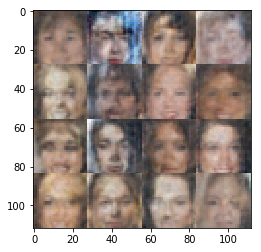

Epoch 1/1... Generator Loss: 0.7351 Discriminator Loss: 1.3968...
Epoch 1/1... Generator Loss: 1.0927 Discriminator Loss: 1.2713...
Epoch 1/1... Generator Loss: 1.1333 Discriminator Loss: 1.2313...
Epoch 1/1... Generator Loss: 1.2142 Discriminator Loss: 1.0356...
Epoch 1/1... Generator Loss: 0.7192 Discriminator Loss: 1.6404...
Epoch 1/1... Generator Loss: 0.8447 Discriminator Loss: 1.3404...
Epoch 1/1... Generator Loss: 0.9646 Discriminator Loss: 1.3553...
Epoch 1/1... Generator Loss: 0.5269 Discriminator Loss: 1.5322...
Epoch 1/1... Generator Loss: 0.9631 Discriminator Loss: 1.4272...
Epoch 1/1... Generator Loss: 0.8112 Discriminator Loss: 1.3128...


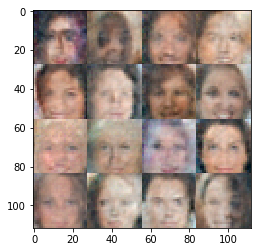

Epoch 1/1... Generator Loss: 0.6138 Discriminator Loss: 1.2888...
Epoch 1/1... Generator Loss: 0.7492 Discriminator Loss: 1.3224...
Epoch 1/1... Generator Loss: 0.8295 Discriminator Loss: 1.3096...
Epoch 1/1... Generator Loss: 0.7927 Discriminator Loss: 1.3026...
Epoch 1/1... Generator Loss: 1.6545 Discriminator Loss: 1.1736...
Epoch 1/1... Generator Loss: 1.6528 Discriminator Loss: 1.6287...
Epoch 1/1... Generator Loss: 0.6661 Discriminator Loss: 1.3771...
Epoch 1/1... Generator Loss: 0.8464 Discriminator Loss: 1.1148...
Epoch 1/1... Generator Loss: 1.7892 Discriminator Loss: 0.5722...
Epoch 1/1... Generator Loss: 1.8718 Discriminator Loss: 2.3549...


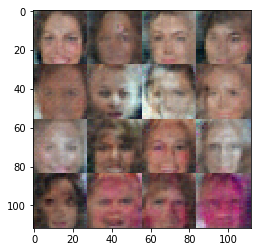

Epoch 1/1... Generator Loss: 0.9665 Discriminator Loss: 1.2718...
Epoch 1/1... Generator Loss: 1.1932 Discriminator Loss: 0.7748...
Epoch 1/1... Generator Loss: 0.7313 Discriminator Loss: 1.5405...
Epoch 1/1... Generator Loss: 0.6036 Discriminator Loss: 1.4140...
Epoch 1/1... Generator Loss: 0.6216 Discriminator Loss: 1.4169...
Epoch 1/1... Generator Loss: 0.8104 Discriminator Loss: 1.3454...
Epoch 1/1... Generator Loss: 0.9216 Discriminator Loss: 1.3329...
Epoch 1/1... Generator Loss: 0.6995 Discriminator Loss: 1.2440...
Epoch 1/1... Generator Loss: 0.9320 Discriminator Loss: 1.5905...
Epoch 1/1... Generator Loss: 0.8953 Discriminator Loss: 1.3634...


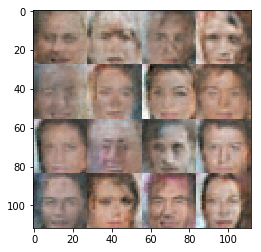

Epoch 1/1... Generator Loss: 0.6791 Discriminator Loss: 1.3311...
Epoch 1/1... Generator Loss: 0.7887 Discriminator Loss: 1.4034...
Epoch 1/1... Generator Loss: 0.5690 Discriminator Loss: 1.4978...
Epoch 1/1... Generator Loss: 0.5959 Discriminator Loss: 1.3987...
Epoch 1/1... Generator Loss: 0.7007 Discriminator Loss: 1.2948...
Epoch 1/1... Generator Loss: 0.8142 Discriminator Loss: 1.2985...
Epoch 1/1... Generator Loss: 0.7117 Discriminator Loss: 1.3214...
Epoch 1/1... Generator Loss: 0.9278 Discriminator Loss: 1.1973...
Epoch 1/1... Generator Loss: 0.4187 Discriminator Loss: 1.8176...
Epoch 1/1... Generator Loss: 0.7896 Discriminator Loss: 1.3431...


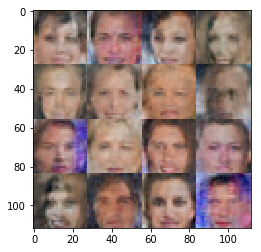

Epoch 1/1... Generator Loss: 0.6248 Discriminator Loss: 1.4197...
Epoch 1/1... Generator Loss: 0.8485 Discriminator Loss: 1.0143...
Epoch 1/1... Generator Loss: 0.8541 Discriminator Loss: 1.3084...
Epoch 1/1... Generator Loss: 0.8037 Discriminator Loss: 1.3282...
Epoch 1/1... Generator Loss: 0.8503 Discriminator Loss: 1.2761...
Epoch 1/1... Generator Loss: 0.9984 Discriminator Loss: 1.5698...
Epoch 1/1... Generator Loss: 0.7340 Discriminator Loss: 1.3495...
Epoch 1/1... Generator Loss: 0.9138 Discriminator Loss: 1.2914...
Epoch 1/1... Generator Loss: 0.7312 Discriminator Loss: 1.3729...
Epoch 1/1... Generator Loss: 0.7086 Discriminator Loss: 1.3135...


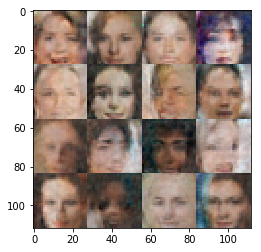

Epoch 1/1... Generator Loss: 0.4280 Discriminator Loss: 1.6605...
Epoch 1/1... Generator Loss: 0.7704 Discriminator Loss: 1.3077...
Epoch 1/1... Generator Loss: 0.6256 Discriminator Loss: 1.4652...
Epoch 1/1... Generator Loss: 0.7459 Discriminator Loss: 1.3405...
Epoch 1/1... Generator Loss: 0.6836 Discriminator Loss: 1.3482...
Epoch 1/1... Generator Loss: 0.8117 Discriminator Loss: 1.3582...
Epoch 1/1... Generator Loss: 0.9529 Discriminator Loss: 1.4040...
Epoch 1/1... Generator Loss: 0.6221 Discriminator Loss: 1.4167...
Epoch 1/1... Generator Loss: 0.6935 Discriminator Loss: 1.3576...
Epoch 1/1... Generator Loss: 0.5749 Discriminator Loss: 1.4266...


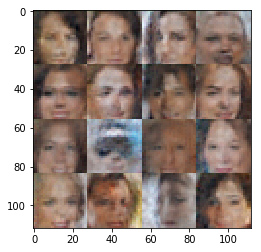

Epoch 1/1... Generator Loss: 0.7768 Discriminator Loss: 1.2693...
Epoch 1/1... Generator Loss: 1.0506 Discriminator Loss: 0.8137...
Epoch 1/1... Generator Loss: 0.9930 Discriminator Loss: 1.3995...
Epoch 1/1... Generator Loss: 0.8063 Discriminator Loss: 1.3569...
Epoch 1/1... Generator Loss: 0.6063 Discriminator Loss: 1.4512...
Epoch 1/1... Generator Loss: 0.6743 Discriminator Loss: 1.3145...
Epoch 1/1... Generator Loss: 0.7318 Discriminator Loss: 1.2842...
Epoch 1/1... Generator Loss: 0.5820 Discriminator Loss: 1.3887...
Epoch 1/1... Generator Loss: 0.7533 Discriminator Loss: 1.3066...
Epoch 1/1... Generator Loss: 0.5816 Discriminator Loss: 1.4078...


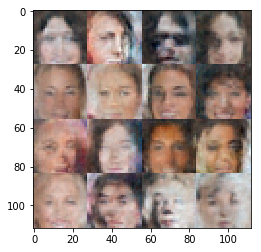

Epoch 1/1... Generator Loss: 0.7239 Discriminator Loss: 1.3230...
Epoch 1/1... Generator Loss: 0.6070 Discriminator Loss: 1.3716...
Epoch 1/1... Generator Loss: 1.6983 Discriminator Loss: 2.0214...
Epoch 1/1... Generator Loss: 0.8491 Discriminator Loss: 1.2423...
Epoch 1/1... Generator Loss: 0.8513 Discriminator Loss: 1.2149...
Epoch 1/1... Generator Loss: 0.4709 Discriminator Loss: 1.5730...
Epoch 1/1... Generator Loss: 0.7056 Discriminator Loss: 1.5321...
Epoch 1/1... Generator Loss: 0.5679 Discriminator Loss: 1.4751...
Epoch 1/1... Generator Loss: 0.8526 Discriminator Loss: 1.3764...
Epoch 1/1... Generator Loss: 0.7985 Discriminator Loss: 1.2054...


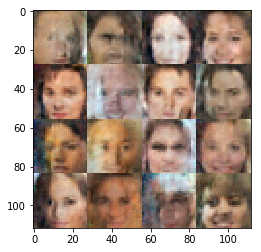

Epoch 1/1... Generator Loss: 1.0368 Discriminator Loss: 1.2010...
Epoch 1/1... Generator Loss: 0.7720 Discriminator Loss: 1.3357...
Epoch 1/1... Generator Loss: 0.9618 Discriminator Loss: 1.3329...
Epoch 1/1... Generator Loss: 0.8927 Discriminator Loss: 1.4098...
Epoch 1/1... Generator Loss: 0.6717 Discriminator Loss: 1.4487...
Epoch 1/1... Generator Loss: 1.0617 Discriminator Loss: 1.1076...
Epoch 1/1... Generator Loss: 0.4831 Discriminator Loss: 1.5387...
Epoch 1/1... Generator Loss: 0.8250 Discriminator Loss: 1.2886...
Epoch 1/1... Generator Loss: 0.8040 Discriminator Loss: 1.2258...
Epoch 1/1... Generator Loss: 0.9999 Discriminator Loss: 1.0613...


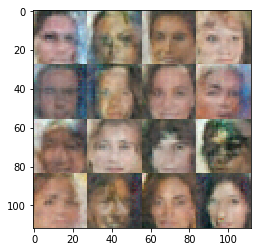

Epoch 1/1... Generator Loss: 0.4183 Discriminator Loss: 1.7057...
Epoch 1/1... Generator Loss: 0.8625 Discriminator Loss: 1.2718...
Epoch 1/1... Generator Loss: 0.7373 Discriminator Loss: 1.2692...
Epoch 1/1... Generator Loss: 0.7847 Discriminator Loss: 1.4001...
Epoch 1/1... Generator Loss: 0.9979 Discriminator Loss: 1.3717...
Epoch 1/1... Generator Loss: 0.7285 Discriminator Loss: 1.2567...
Epoch 1/1... Generator Loss: 0.8638 Discriminator Loss: 1.2441...
Epoch 1/1... Generator Loss: 0.9818 Discriminator Loss: 1.1139...
Epoch 1/1... Generator Loss: 1.1862 Discriminator Loss: 1.3511...
Epoch 1/1... Generator Loss: 0.7937 Discriminator Loss: 1.3093...


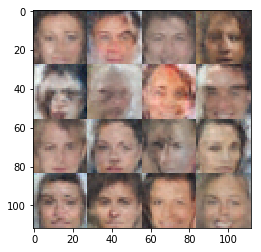

Epoch 1/1... Generator Loss: 0.7465 Discriminator Loss: 1.1634...
Epoch 1/1... Generator Loss: 1.1381 Discriminator Loss: 1.4860...
Epoch 1/1... Generator Loss: 0.7453 Discriminator Loss: 1.2760...
Epoch 1/1... Generator Loss: 0.4548 Discriminator Loss: 1.6109...
Epoch 1/1... Generator Loss: 0.7459 Discriminator Loss: 1.3064...


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.